Detects people in a webcam stream. 

Based on tutorial
https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=bX0rqK-A3Nbl

Just added webcam stream capture and bounding box drawing logic. 

See also webcam.py on this repo for a standalon implementation (inference only)

GPU Requirement: At least 8GB RAM (I tried this on 1080TI and larger GPU's)


In [1]:
# Import the required modules
%pylab inline 
import cv2
from IPython.display import clear_output



Populating the interactive namespace from numpy and matplotlib


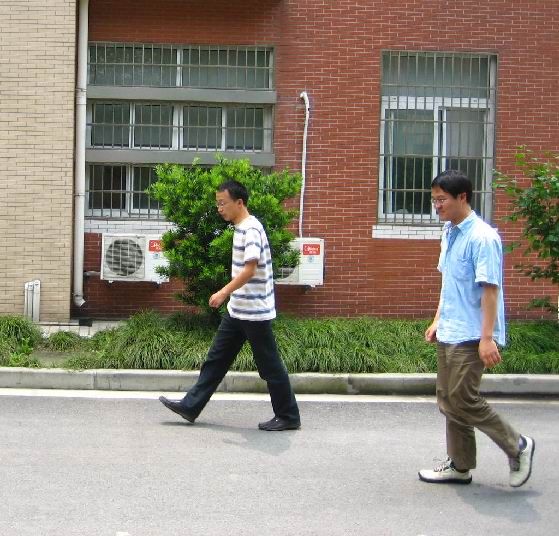

In [2]:
from PIL import Image
data_folder = "/data/"
Image.open(data_folder + 'PennFudanPed/PNGImages/FudanPed00001.png')

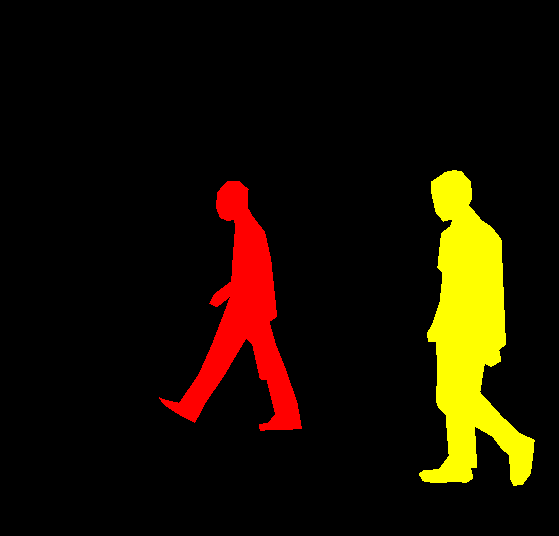

In [3]:
mask = Image.open(data_folder + 'PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

from PennFudanDataset import PennFudanDataset
from PennFudanDataset import PennFudanDatasetEval


In [5]:
dataset = PennFudanDataset(data_folder + 'PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FCCE3235C90>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


#def get_model_instance_segmentation(num_classes):
def get_instance_segmentation_model(num_classes):    
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
class PennFudanDatasetEval(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))
        

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.imgs[idx])
        
        img = Image.open(img_path).convert("RGB")
        
        image_id = torch.tensor([idx])

        if self.transforms is not None:
            img, _ = self.transforms(img, None)

        return img

    def __len__(self):
        return len(self.imgs)
    
eval_folder = "./eval"
dataset_eval = PennFudanDatasetEval(eval_folder, get_transform(train=False))
dataset_eval[0]    

tensor([[[0.9373, 0.9373, 0.9373,  ..., 0.7333, 0.7333, 0.7294],
         [0.9294, 0.9333, 0.9333,  ..., 0.7412, 0.7490, 0.7412],
         [0.9216, 0.9255, 0.9255,  ..., 0.7451, 0.7529, 0.7451],
         ...,
         [0.7608, 0.7569, 0.7490,  ..., 0.0471, 0.0392, 0.0275],
         [0.7686, 0.7608, 0.7569,  ..., 0.0314, 0.0275, 0.0235],
         [0.7686, 0.7686, 0.7608,  ..., 0.0157, 0.0235, 0.0196]],

        [[0.9373, 0.9373, 0.9373,  ..., 0.8078, 0.8000, 0.7882],
         [0.9373, 0.9373, 0.9373,  ..., 0.8000, 0.8000, 0.7843],
         [0.9294, 0.9294, 0.9333,  ..., 0.7922, 0.7961, 0.7882],
         ...,
         [0.6314, 0.6275, 0.6275,  ..., 0.0314, 0.0314, 0.0275],
         [0.6314, 0.6235, 0.6196,  ..., 0.0353, 0.0275, 0.0235],
         [0.6196, 0.6196, 0.6235,  ..., 0.0392, 0.0314, 0.0235]],

        [[0.9098, 0.8980, 0.9059,  ..., 0.7569, 0.7569, 0.7569],
         [0.9098, 0.9059, 0.9059,  ..., 0.7647, 0.7686, 0.7686],
         [0.9059, 0.9098, 0.9098,  ..., 0.7608, 0.7686, 0.

In [9]:
# use our dataset and defined transformations
dataset = PennFudanDataset(data_folder + 'PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset(data_folder + 'PennFudanPed', get_transform(train=False))

# @jose addeed eval images (no mask)
dataset_eval = PennFudanDatasetEval(eval_folder, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [17]:
# let's train it for 10 epochs
num_epochs = 10
model_checkpoint_file = "./pedestrian.pt"

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
    # save checkpoint
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, model_checkpoint_file)


Epoch: [0]  [ 0/60]  eta: 0:00:40  lr: 0.000090  loss: 0.1507 (0.1507)  loss_classifier: 0.0278 (0.0278)  loss_box_reg: 0.0056 (0.0056)  loss_mask: 0.1139 (0.1139)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.6790  data: 0.2624  max mem: 3596
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 0.1507 (0.1738)  loss_classifier: 0.0278 (0.0262)  loss_box_reg: 0.0077 (0.0141)  loss_mask: 0.1139 (0.1251)  loss_objectness: 0.0006 (0.0009)  loss_rpn_box_reg: 0.0061 (0.0075)  time: 0.4039  data: 0.0287  max mem: 3596
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 0.1493 (0.1635)  loss_classifier: 0.0291 (0.0258)  loss_box_reg: 0.0094 (0.0127)  loss_mask: 0.1034 (0.1171)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0061 (0.0072)  time: 0.3687  data: 0.0058  max mem: 3596
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.1547 (0.1731)  loss_classifier: 0.0300 (0.0295)  loss_box_reg: 0.0122 (0.0143)  loss_mask: 0.1096 (0.1201)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:32  lr: 0.000500  loss: 0.1763 (0.1763)  loss_classifier: 0.0358 (0.0358)  loss_box_reg: 0.0100 (0.0100)  loss_mask: 0.1239 (0.1239)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 0.5368  data: 0.2021  max mem: 3596
Epoch: [2]  [10/60]  eta: 0:00:19  lr: 0.000500  loss: 0.1389 (0.1466)  loss_classifier: 0.0210 (0.0222)  loss_box_reg: 0.0076 (0.0093)  loss_mask: 0.1045 (0.1070)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0062 (0.0077)  time: 0.3944  data: 0.0248  max mem: 3596
Epoch: [2]  [20/60]  eta: 0:00:14  lr: 0.000500  loss: 0.1337 (0.1401)  loss_classifier: 0.0199 (0.0206)  loss_box_reg: 0.0060 (0.0078)  loss_mask: 0.1008 (0.1047)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0052 (0.0066)  time: 0.3654  data: 0.0069  max mem: 3596
Epoch: [2]  [30/60]  eta: 0:00:11  lr: 0.000500  loss: 0.1337 (0.1407)  loss_classifier: 0.0202 (0.0203)  loss_box_reg: 0.0062 (0.0081)  loss_mask: 0.0996 (0.1049)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:34  lr: 0.000500  loss: 0.1238 (0.1238)  loss_classifier: 0.0079 (0.0079)  loss_box_reg: 0.0055 (0.0055)  loss_mask: 0.1071 (0.1071)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 0.5668  data: 0.2201  max mem: 3599
Epoch: [4]  [10/60]  eta: 0:00:18  lr: 0.000500  loss: 0.1305 (0.1351)  loss_classifier: 0.0169 (0.0192)  loss_box_reg: 0.0055 (0.0060)  loss_mask: 0.1055 (0.1030)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0062 (0.0064)  time: 0.3669  data: 0.0252  max mem: 3599
Epoch: [4]  [20/60]  eta: 0:00:14  lr: 0.000500  loss: 0.1331 (0.1410)  loss_classifier: 0.0196 (0.0208)  loss_box_reg: 0.0053 (0.0068)  loss_mask: 0.1025 (0.1065)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0058 (0.0065)  time: 0.3467  data: 0.0059  max mem: 3599
Epoch: [4]  [30/60]  eta: 0:00:10  lr: 0.000500  loss: 0.1373 (0.1454)  loss_classifier: 0.0191 (0.0210)  loss_box_reg: 0.0053 (0.0074)  loss_mask: 0.1063 (0.1100)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:45  lr: 0.000050  loss: 0.1340 (0.1340)  loss_classifier: 0.0270 (0.0270)  loss_box_reg: 0.0035 (0.0035)  loss_mask: 0.0978 (0.0978)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.7573  data: 0.3805  max mem: 3599
Epoch: [6]  [10/60]  eta: 0:00:19  lr: 0.000050  loss: 0.1329 (0.1279)  loss_classifier: 0.0147 (0.0167)  loss_box_reg: 0.0052 (0.0048)  loss_mask: 0.0983 (0.1003)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 0.3801  data: 0.0378  max mem: 3599
Epoch: [6]  [20/60]  eta: 0:00:14  lr: 0.000050  loss: 0.1310 (0.1401)  loss_classifier: 0.0155 (0.0185)  loss_box_reg: 0.0055 (0.0078)  loss_mask: 0.0998 (0.1075)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0056 (0.0058)  time: 0.3485  data: 0.0050  max mem: 3599
Epoch: [6]  [30/60]  eta: 0:00:10  lr: 0.000050  loss: 0.1310 (0.1406)  loss_classifier: 0.0175 (0.0189)  loss_box_reg: 0.0056 (0.0073)  loss_mask: 0.0998 (0.1076)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:37  lr: 0.000005  loss: 0.1376 (0.1376)  loss_classifier: 0.0156 (0.0156)  loss_box_reg: 0.0059 (0.0059)  loss_mask: 0.1062 (0.1062)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 0.6180  data: 0.2399  max mem: 3599
Epoch: [8]  [10/60]  eta: 0:00:18  lr: 0.000005  loss: 0.1304 (0.1326)  loss_classifier: 0.0156 (0.0190)  loss_box_reg: 0.0041 (0.0049)  loss_mask: 0.1024 (0.1021)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0057 (0.0060)  time: 0.3682  data: 0.0267  max mem: 3599
Epoch: [8]  [20/60]  eta: 0:00:14  lr: 0.000005  loss: 0.1304 (0.1396)  loss_classifier: 0.0194 (0.0210)  loss_box_reg: 0.0051 (0.0067)  loss_mask: 0.1024 (0.1050)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0059 (0.0063)  time: 0.3612  data: 0.0059  max mem: 3599
Epoch: [8]  [30/60]  eta: 0:00:11  lr: 0.000005  loss: 0.1500 (0.1420)  loss_classifier: 0.0216 (0.0213)  loss_box_reg: 0.0069 (0.0072)  loss_mask: 0.1028 (0.1060)  loss_ob

In [21]:
# load base model 
num_classes = 2
model = get_instance_segmentation_model(num_classes)

#optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(model_checkpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.to(device)
model.eval()

# - or -
#model.train()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [22]:
# pick one image from the test set
#img, _ = dataset_test[10]
img = dataset_eval[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

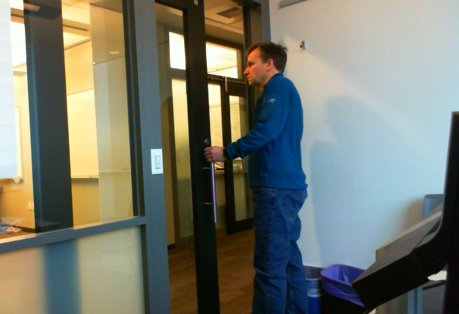

In [23]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

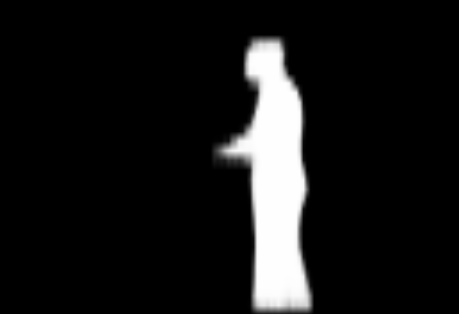

In [24]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

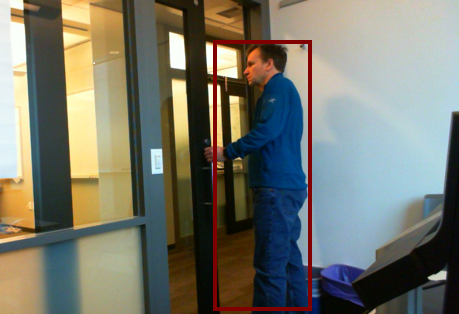

In [25]:
from PIL import Image, ImageDraw

box = prediction[0]['boxes'][0]

im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

draw = ImageDraw.Draw(im)
draw.rectangle((box[0], box[1], box[2], box[3]), outline=128, width=4)
del draw

im


In [26]:
# You can also give path to the video file
vid = cv2.VideoCapture(0)

model.eval()
trx = get_transform(False)

# Put the code in try-except statements
# Catch the keyboard exception and 
# release the camera device and 
# continue with the rest of code.
try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            # Message to be displayed after releasing the device
            print ("Released Video Resource")
            break
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        img, _ = trx(frame, None)
        
        with torch.no_grad():
            prediction = model([img.to(device)])
            if (len(prediction[0]['boxes']) > 0):
                box = prediction[0]['boxes'][0]
                im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
                draw = ImageDraw.Draw(im)
                draw.rectangle((box[0], box[1], box[2], box[3]), outline=128, width=4)
                del draw
                frame = im
        
        # Turn off the axis
        axis('off')
        # Title of the window
        title("Input Stream")
        # Display the frame
        imshow(frame)
        #print(frame.shape)
        show()
        # Display the frame until new frame is available
        clear_output(wait=True) 
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    print ("(2)Released Video Resource")
    


(2)Released Video Resource
